In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
folder_path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"
folder_path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

folder_no = os.listdir(folder_path_no)
folder_yes = os.listdir(folder_path_yes)

print(len(folder_no))
print(len(folder_yes))

1341
3875


In [4]:
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/"
path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/"

img_width, img_height = 224, 224


data_no = np.array([img_to_array(load_img(path_no + img, target_size=(img_width, img_height))) for img in os.listdir(path_no)])
data_yes = np.array([img_to_array(load_img(path_yes + img, target_size=(img_width, img_height))) for img in os.listdir(path_yes)])

labels_no = np.zeros(len(data_no))
labels_yes = np.ones(len(data_yes))

data = np.concatenate([data_no, data_yes])
labels = np.concatenate([labels_no, labels_yes])

data, labels = shuffle(data, labels, random_state=42)
data_train=data/255.0

In [5]:
folder_path_test_normal = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/"
folder_path_test_pneumonia = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/"

folder_test_no = os.listdir(folder_path_test_normal)
folder_test_yes = os.listdir(folder_path_test_pneumonia)

print(len(folder_test_no))
print(len(folder_test_yes))

234
390


In [6]:
test_no_label = [0]*len(folder_test_no)
test_yes_label = [1]*len(folder_test_yes)
test_labels = test_no_label + test_yes_label
print(len(test_labels))

624


In [7]:
path_no = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/"
path_yes = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/"

img_width, img_height = 224, 224

datagen = ImageDataGenerator(rescale=1./255)

data_no = np.array([img_to_array(load_img(path_no + img, target_size=(img_width, img_height))) for img in os.listdir(path_no)])
data_yes = np.array([img_to_array(load_img(path_yes + img, target_size=(img_width, img_height))) for img in os.listdir(path_yes)])

labels_no = np.zeros(len(data_no))
labels_yes = np.ones(len(data_yes))

data_test = np.concatenate([data_no, data_yes])
labels_test = np.concatenate([labels_no, labels_yes])

data_test_shuffled, labels_test_shuffled = shuffle(data_test, labels_test, random_state=42)

In [8]:
data_test_normalised=data_test_shuffled/255.0

In [9]:
data.shape

(5216, 224, 224, 3)

In [10]:
data_test_normalised.shape

(624, 224, 224, 3)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(data_train, labels, test_size=0.2, random_state=42)
x_test = np.concatenate([x_val, data_test_normalised])
y_test = np.concatenate([y_val, labels_test_shuffled])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

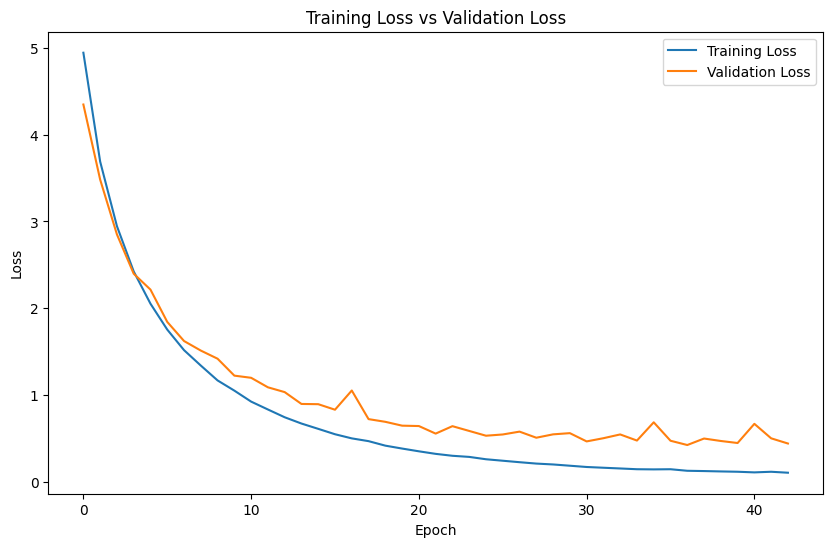

53/53 [==============================] - 3s 47ms/step - loss: 0.4232 - accuracy: 0.9065
Test Loss: 0.4232
Test Accuracy: 90.65%


In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with regularization
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

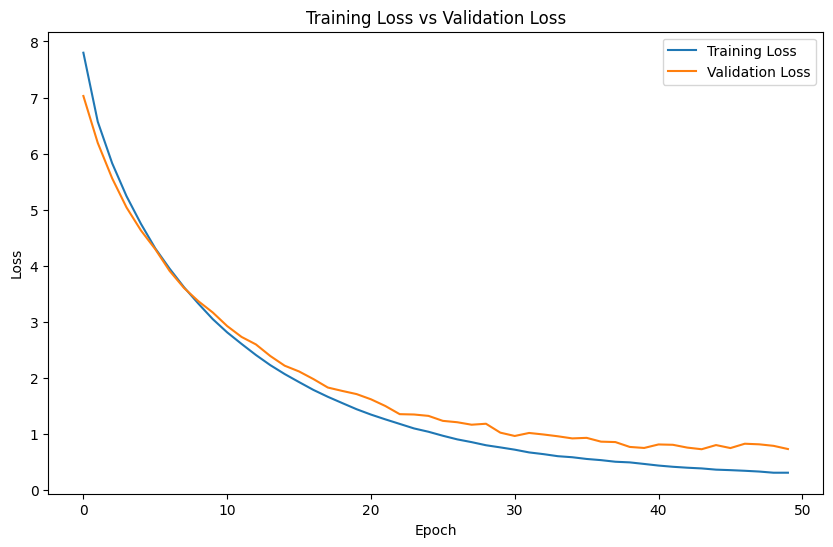

53/53 [==============================] - 3s 47ms/step - loss: 0.7310 - accuracy: 0.9017
Test Loss: 0.7310
Test Accuracy: 90.17%


In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with regularization
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.7))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.7))
# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

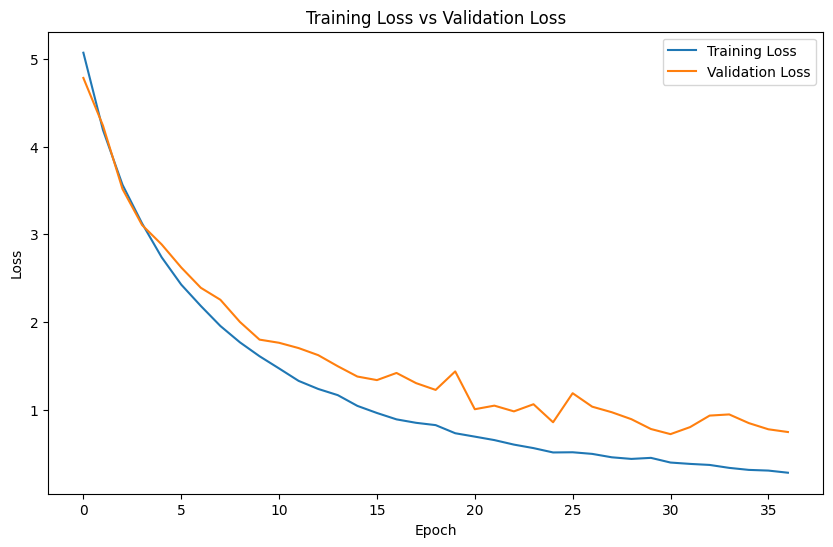

53/53 [==============================] - 3s 47ms/step - loss: 0.7195 - accuracy: 0.9131
Test Loss: 0.7195
Test Accuracy: 91.31%


In [18]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch 1

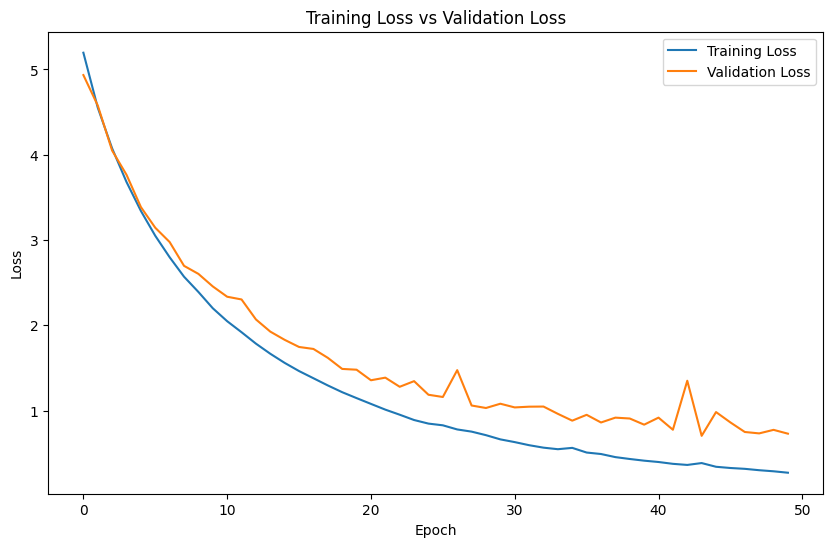

53/53 [==============================] - 4s 48ms/step - loss: 0.7047 - accuracy: 0.9119
Test Loss: 0.7047
Test Accuracy: 91.19%


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00003), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 48018209 (183.17 MB)
Trainable params: 26215425 (100.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoc

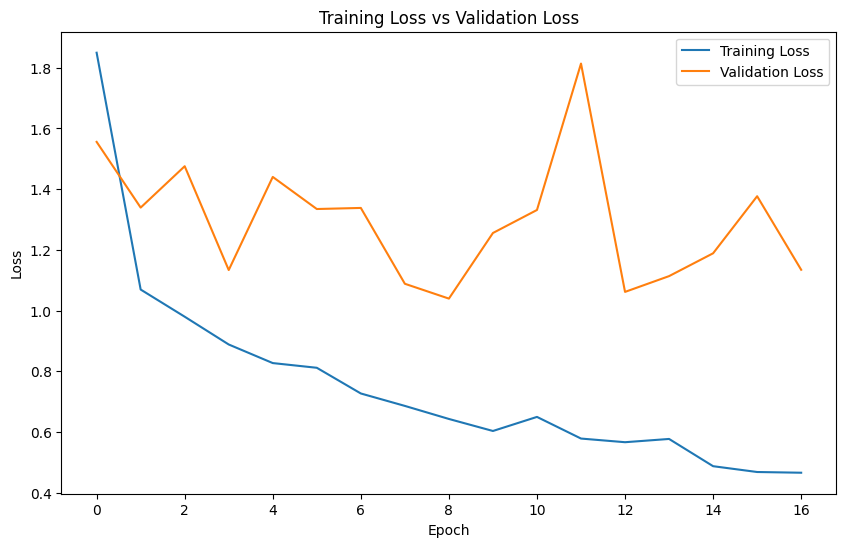

53/53 [==============================] - 3s 47ms/step - loss: 1.0395 - accuracy: 0.9161
Test Loss: 1.0395
Test Accuracy: 91.61%


In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(512, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

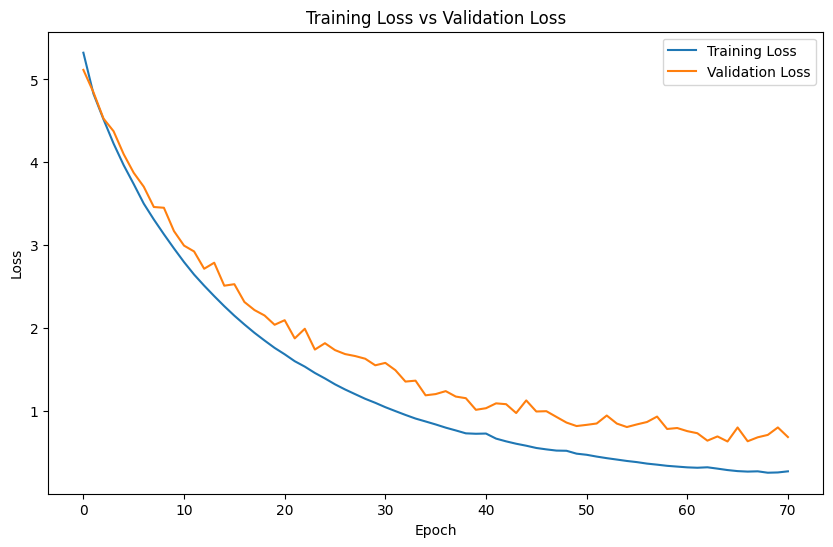

53/53 [==============================] - 3s 47ms/step - loss: 0.6361 - accuracy: 0.9119
Test Loss: 0.6361
Test Accuracy: 91.19%


In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00002), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

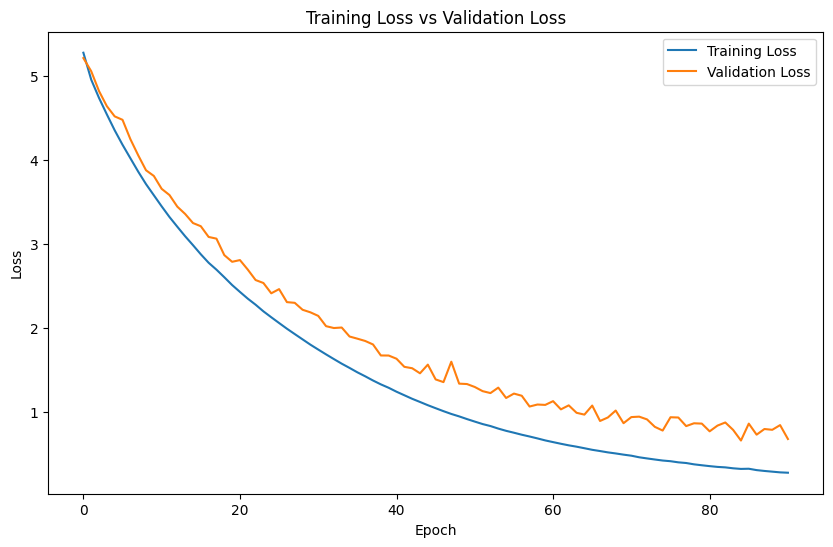

53/53 [==============================] - 3s 47ms/step - loss: 0.6542 - accuracy: 0.9137
Test Loss: 0.6542
Test Accuracy: 91.37%


In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

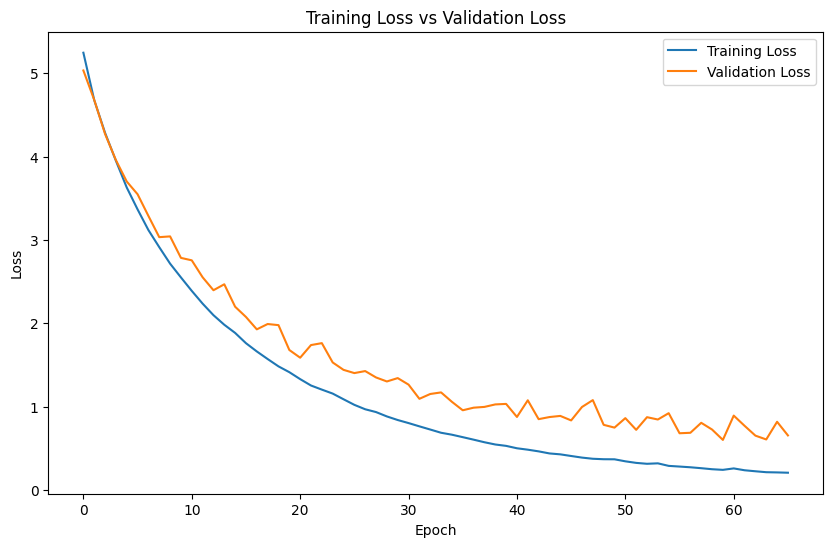

53/53 [==============================] - 3s 47ms/step - loss: 0.6016 - accuracy: 0.9125
Test Loss: 0.6016
Test Accuracy: 91.25%


In [17]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.000025), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 51200)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

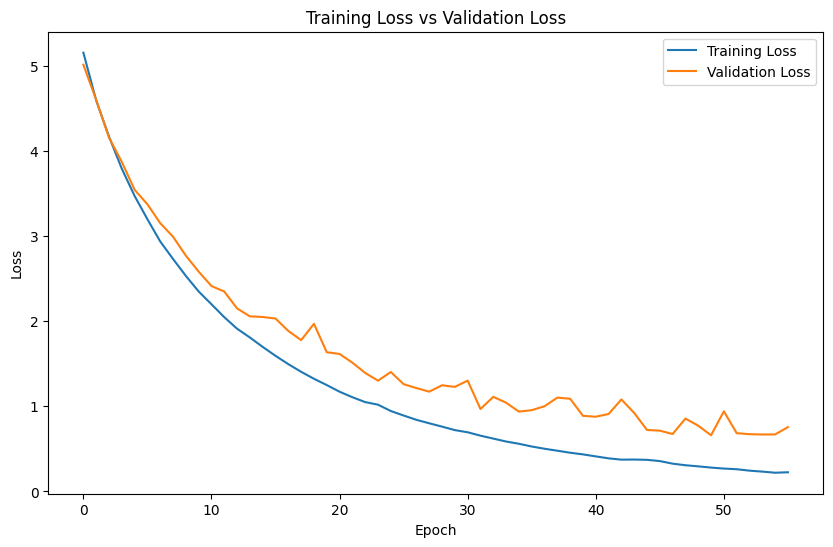

53/53 [==============================] - 2s 46ms/step - loss: 0.6595 - accuracy: 0.9137
Test Loss: 0.6595
Test Accuracy: 91.37%


In [19]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.000025), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

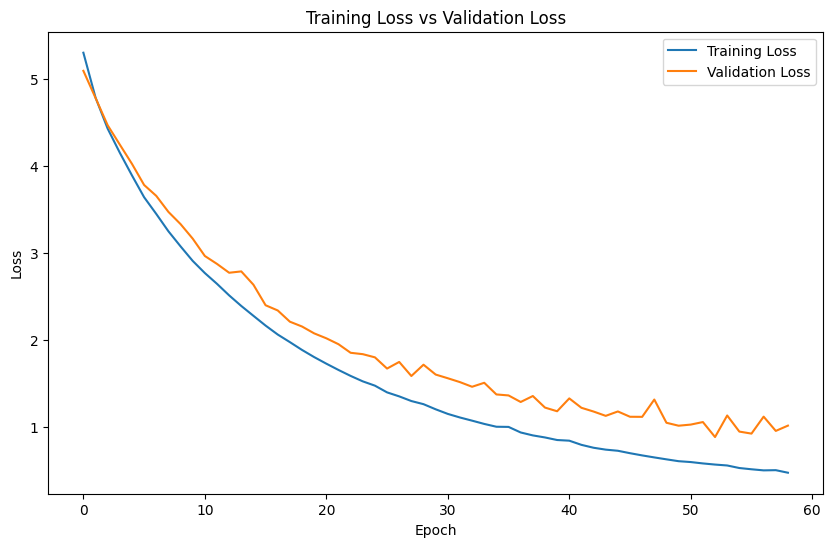

53/53 [==============================] - 3s 47ms/step - loss: 0.8812 - accuracy: 0.9125
Test Loss: 0.8812
Test Accuracy: 91.25%


In [18]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with LeakyReLU activation and regularization
model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.8))


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.000025), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34910497 (133.17 MB)
Trainable params: 13107713 (50.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch

I0000 00:00:1706725444.752301     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 [==============================] - 34s 307ms/step - loss: 4.9662 - accuracy: 0.8737 - val_loss: 4.3560 - val_accuracy: 0.8909
Epoch 2/50
66/66 [==============================] - 12s 181ms/step - loss: 3.7730 - accuracy: 0.9535 - val_loss: 3.5091 - val_accuracy: 0.8999
Epoch 3/50
66/66 [==============================] - 12s 182ms/step - loss: 3.0473 - accuracy: 0.9633 - val_loss: 3.0022 - val_accuracy: 0.8903
Epoch 4/50
66/66 [==============================] - 12s 184ms/step - loss: 2.5419 - accuracy: 0.9676 - val_loss: 2.5134 - val_accuracy: 0.9161
Epoch 5/50
66/66 [==============================] - 12s 186ms/step - loss: 2.1504 - accuracy: 0.9787 - val_loss: 2.3026 - val_accuracy: 0.8831
Epoch 6/50
66/66 [==============================] - 12s 186ms/step - loss: 1.8615 - accuracy: 0.9760 - val_loss: 1.9328 - val_accuracy: 0.9173
Epoch 7/50
66/66 [==============================] - 12s 184ms/step - loss: 1.6235 - accuracy: 0.9791 - val_loss: 1.7333 - val_accuracy: 0.9119
Epoch 8/50

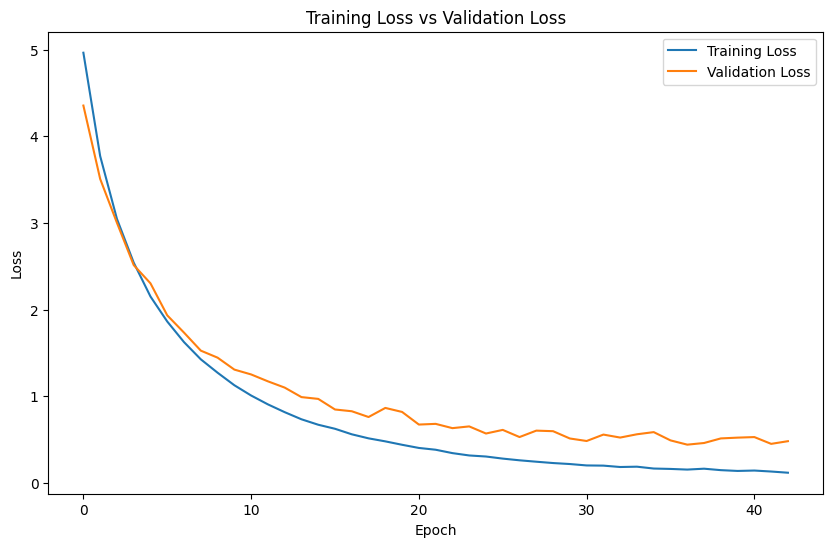

53/53 [==============================] - 7s 67ms/step - loss: 0.4394 - accuracy: 0.9179
Test Loss: 0.4394
Test Accuracy: 91.79%
53/53 [==============================] - 5s 66ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86       519
         1.0       0.92      0.97      0.94      1149

    accuracy                           0.92      1668
   macro avg       0.92      0.89      0.90      1668
weighted avg       0.92      0.92      0.92      1668



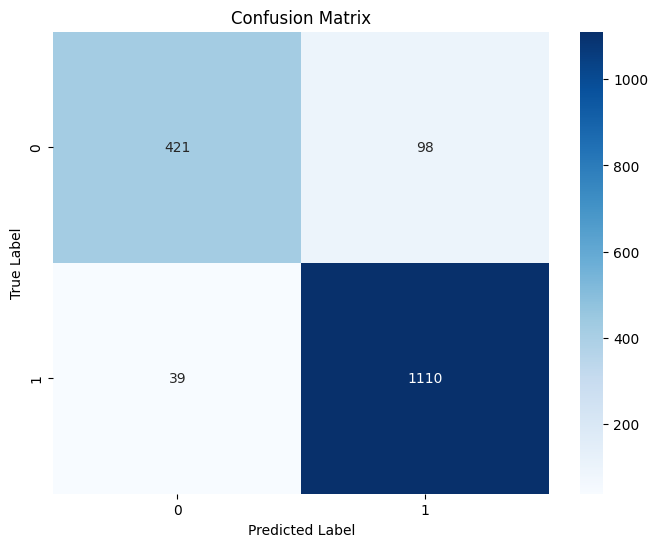

In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the pre-trained InceptionV3 model
model.add(pre_trained_model)

# Flatten layer
model.add(Flatten())

# Fully connected layers with regularization
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
